In [1]:
import math
import numpy as np
import pandas as pd
import os
import random
import re
import spacy
import matplotlib.pyplot as plt

from glob import glob
from sklearn.model_selection import train_test_split
from tqdm import notebook, tqdm_notebook

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch import optim
from torch.nn.utils import clip_grad_norm_
from torch.autograd import Variable
from torchtext.data import Field, BPTTIterator, BucketIterator, Iterator, TabularDataset, interleave_keys
from torchtext import data

In [3]:
from rouge import Rouge

## Load data

In [2]:
glob('../data/news-summary-kaggle/*')

['../data/news-summary-kaggle/news_test.csv',
 '../data/news-summary-kaggle/news_train.csv',
 '../data/news-summary-kaggle/news_summary_more.csv',
 '../data/news-summary-kaggle/news-cleaned.csv',
 '../data/news-summary-kaggle/news-splitted.csv',
 '../data/news-summary-kaggle/news_summary.csv',
 '../data/news-summary-kaggle/news_val.csv']

In [3]:
data = pd.read_csv('../data/news-summary-kaggle/news_summary.csv', encoding='iso-8859-2')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4514 entries, 0 to 4513
Data columns (total 6 columns):
author       4514 non-null object
date         4514 non-null object
headlines    4514 non-null object
read_more    4514 non-null object
text         4514 non-null object
ctext        4396 non-null object
dtypes: object(6)
memory usage: 211.7+ KB


In [5]:
data.head()

,author,date,headlines,read_more,text,ctext
0,Chhavi Tyagi,"03 Aug 2017,Thursday",Daman & Diu revokes mandatory Rakshabandhan in...,http://www.hindustantimes.com/india-news/raksh...,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Daisy Mowke,"03 Aug 2017,Thursday",Malaika slams user who trolled her for 'divorc...,http://www.hindustantimes.com/bollywood/malaik...,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,Arshiya Chopra,"03 Aug 2017,Thursday",'Virgin' now corrected to 'Unmarried' in IGIMS...,http://www.hindustantimes.com/patna/bihar-igim...,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Sumedha Sehra,"03 Aug 2017,Thursday",Aaj aapne pakad liya: LeT man Dujana before be...,http://indiatoday.intoday.in/story/abu-dujana-...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Aarushi Maheshwari,"03 Aug 2017,Thursday",Hotel staff to get training to spot signs of s...,http://indiatoday.intoday.in/story/sex-traffic...,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


In [6]:
data_more = pd.read_csv('../data/news-summary-kaggle/news_summary_more.csv', encoding='iso-8859-2')

In [7]:
data_more.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


## Merge and filter data

In [8]:
raw_data = pd.DataFrame({
    'text': pd.concat([data.text, data_more.text], ignore_index=True),
    'summary': pd.concat([data.headlines, data_more.headlines], ignore_index=True)
})

In [9]:
raw_data.head()

,text,summary
0,The Administration of Union Territory Daman an...,Daman & Diu revokes mandatory Rakshabandhan in...
1,Malaika Arora slammed an Instagram user who tr...,Malaika slams user who trolled her for 'divorc...
2,The Indira Gandhi Institute of Medical Science...,'Virgin' now corrected to 'Unmarried' in IGIMS...
3,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Aaj aapne pakad liya: LeT man Dujana before be...
4,Hotels in Maharashtra will train their staff t...,Hotel staff to get training to spot signs of s...


In [10]:
raw_data['text_len'] = raw_data.text.apply(lambda x: len(x))
raw_data['summary_len'] = raw_data.summary.apply(lambda x: len(x))

In [11]:
raw_data.text_len.hist(bins=50)

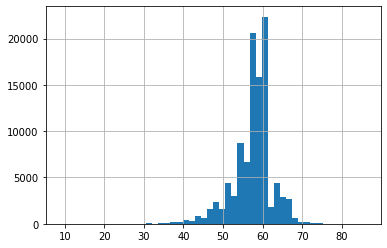

In [12]:
raw_data.summary_len.hist(bins=50)

### Remove shortest summaries

In [13]:
raw_data = raw_data[raw_data.summary_len > raw_data.summary_len.quantile(.01)]

In [14]:
nlp = spacy.load('en', disable=['ner', 'parser'])

In [17]:
def spacy_strip(row):
    row=re.sub("(\\t)", ' ', str(row))
    row=re.sub("(\\r)", ' ', str(row))
    row=re.sub("(\\n)", ' ', str(row))

    row=re.sub("(__+)", ' ', str(row))
    row=re.sub("(-+)", ' ', str(row))
    row=re.sub("(~~+)", ' ', str(row))
    row=re.sub("(\+\++)", ' ', str(row))
    row=re.sub("(\.\.+)", ' ', str(row))

    row=re.sub("(\.\s+)", ' ', str(row))
    row=re.sub("(\-\s+)", ' ', str(row))
    row=re.sub("(\:\s+)", ' ', str(row))

    row=re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", '', str(row))

    parsed = nlp(row)
    lemmatized = ''
    for sentence in parsed:
        lemmatized += sentence.lemma_.strip() + ' '
    return lemmatized.lstrip().rstrip()

In [18]:
raw_data['text_stripped'] = [
    spacy_strip(row) for row in tqdm_notebook(raw_data.text)
]

In [19]:
raw_data['summary_stripped'] = [
    spacy_strip(row) for row in tqdm_notebook(raw_data.summary)
]

In [ ]:
# raw_data.to_csv('../data/news-summary-kaggle/news-cleaned.csv')

## Separate to train, val and test

In [337]:
data = pd.read_csv('../data/news-summary-kaggle/news-cleaned.csv', index_col=0)

In [338]:
data.reset_index(drop=True, inplace=True)

In [339]:
data.head()

,text,summary,text_len,summary_len,text_stripped,summary_stripped
0,The Administration of Union Territory Daman an...,Daman & Diu revokes mandatory Rakshabandhan in...,358,60,the Administration of Union Territory Daman an...,Daman Diu revoke mandatory Rakshabandhan in o...
1,Malaika Arora slammed an Instagram user who tr...,Malaika slams user who trolled her for 'divorc...,361,60,Malaika Arora slam an Instagram user who troll...,Malaika slam user who troll -PRON- for divorce...
2,The Indira Gandhi Institute of Medical Science...,'Virgin' now corrected to 'Unmarried' in IGIMS...,398,52,the Indira Gandhi Institute of Medical Science...,Virgin now correct to Unmarried in IGIMS form
3,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Aaj aapne pakad liya: LeT man Dujana before be...,368,56,Lashkar e Taibas Kashmir commander Abu Dujana ...,Aaj aapne pakad liya LeT man Dujana before be ...
4,Hotels in Maharashtra will train their staff t...,Hotel staff to get training to spot signs of s...,366,60,hotel in Maharashtra will train -PRON- staff t...,hotel staff to get training to spot sign of se...


In [340]:
def train_val_test_split(df, train_percentage=0.8, val_percentage=0.1, seed=None, inplace=False):
    np.random.seed(seed)
    permutation = np.random.permutation(df.index)
    length = len(df.index)
    train_end = int(train_percentage * length)
    val_end = int(val_percentage * length) + train_end
    train_ids = permutation[:train_end]
    val_ids = permutation[train_end:val_end]
    test_ids = permutation[val_end:]
    if inplace:
        df.loc[df.index.isin(train_ids), 'dataset'] = ['train'] * len(train_ids)
        df.loc[df.index.isin(val_ids), 'dataset'] = ['val'] * len(val_ids)
        df.loc[df.index.isin(test_ids), 'dataset'] = ['test'] * len(test_ids)
        return df
    else:
        train = df.iloc[train_ids]
        val = df.iloc[val_ids]
        test = df.iloc[test_ids]
        return train.reset_index(drop=True), val.reset_index(drop=True), test.reset_index(drop=True)

In [341]:
train_data, val_data, test_data = train_val_test_split(data, seed=9, inplace=False)

In [342]:
train_data.head()

,text,summary,text_len,summary_len,text_stripped,summary_stripped
0,The I-League organisers said on Monday that th...,No telecast of Real Kashmir vs Chennai City du...,327,55,the I League organiser say on Monday that the ...,no telecast of Real Kashmir vs Chennai City du...
1,"Poland-born scientist Marie Curie, known for h...",Marie Curie unknowingly died due to her own di...,350,53,Poland bear scientist Marie Curie know for -PR...,Marie Curie unknowingly die due to -PRON- own ...
2,US State Secretary Mike Pompeo has announced t...,US to revoke visas of 21 Saudis involved in jo...,377,60,US State Secretary Mike Pompeo have announce t...,US to revoke visa of 21 Saudis involve in jour...
3,British DJ Paul Oakenfold on Tuesday performed...,British DJ Paul Oakenfold performs concert at ...,353,59,british DJ Paul Oakenfold on Tuesday perform a...,british DJ Paul Oakenfold perform concert at M...
4,"Bihar's Somesh Choudhary, a ticket examiner in...",Indian Railways employee asked PNR full form o...,368,66,Bihars Somesh Choudhary a ticket examiner in I...,Indian Railways employee ask PNR full form on ...


### Save data as separate datasets:
* train
* val
* test

In [644]:
train_data[['text_stripped', 'summary_stripped']].to_csv('../data/news-summary-kaggle/news_train.csv')
val_data[['text_stripped', 'summary_stripped']].to_csv('../data/news-summary-kaggle/news_val.csv')
test_data[['text_stripped', 'summary_stripped']].to_csv('../data/news-summary-kaggle/news_test.csv')

In [4]:
nlp = spacy.load('en', disable=['ner', 'parser'])

In [5]:
def tokenize_en(text):
    text=re.sub("(\\t)", ' ', str(text))
    text=re.sub("(\\r)", ' ', str(text))
    text=re.sub("(\\n)", ' ', str(text))

    text=re.sub("(__+)", ' ', str(text))
    text=re.sub("(-+)", ' ', str(text))
    text=re.sub("(~~+)", ' ', str(text))
    text=re.sub("(\+\++)", ' ', str(text))
    text=re.sub("(\.\.+)", ' ', str(text))

    text=re.sub("(\.\s+)", ' ', str(text))
    text=re.sub("(\-\s+)", ' ', str(text))
    text=re.sub("(\:\s+)", ' ', str(text))

    text=re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", '', str(text))
    return [tok.text for tok in nlp.tokenizer(text)]

## Get dataset

In [9]:
def load_dataset(batch_size):
    TEXT = Field(tokenize=tokenize_en, include_lengths=True,
                 init_token='<sos>', eos_token='<eos>')
    SUMMARY = Field(tokenize=tokenize_en, include_lengths=True,
                    init_token='<sos>', eos_token='<eos>')
    train, val, test = TabularDataset.splits(
        skip_header=True, 
        path='../../data/news-summary-kaggle/', format='csv', 
        fields=[('index', None), ('text', TEXT), ('summary', SUMMARY), ],
        train='news_train.csv', validation='news_val.csv', test='news_test.csv'
    )
    TEXT.build_vocab(train, min_freq=2)
    SUMMARY.vocab = TEXT.vocab
    train_iter, val_iter, test_iter = BucketIterator.splits(
        (train, val, test), 
        batch_size=batch_size, 
        sort_key=lambda x: interleave_keys(len(x.text), len(x.summary)), 
        sort=True, 
        repeat=False,
    )
    return train_iter, val_iter, test_iter, TEXT, SUMMARY

In [10]:
batch_size = 64

In [11]:
train_iter, val_iter, test_iter, TEXT, SUMMARY = load_dataset(batch_size)

In [37]:
def indices_from_text(text, lang=TEXT):
    indices = []
    for word in text.strip().split(' '):
        indices.append(lang.vocab.stoi[word])
    return torch.LongTensor(indices)

In [14]:
def text_from_indices(indices, lang=TEXT):
    text = ""
    for element in indices:
        if type(element) is torch.Tensor:
            text += lang.vocab.itos[element.item()] + " "
        else:
            text += lang.vocab.itos[element] + " "
    return text

#### Random text

In [15]:
batch = next(iter(train_iter))

In [16]:
text_from_indices(batch.text[0][:, 0])

'<sos> Actor Diljit Dosanjhs look from the upcoming comedy film Arjun Patiala have be reveal Diljit can be see dress as a police officer in the first look direct by filmmaker Rohit Jugraj and also star actor Varun Sharma and Kriti Sanon Arjun Patiala be schedule to release on September 13 . <eos> '

#### Random summary

In [17]:
text_from_indices(batch.summary[0][:, 0])

'<sos> Diljit Dosanjhs look from Arjun Patiala reveal <eos> <pad> <pad> <pad> <pad> <pad> <pad> '

## Seq2Seq model

In [18]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, n_layers=1, dropout=0.1):
        super(EncoderRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.embedding_size = embedding_size
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.gru = nn.GRU(embedding_size, hidden_size, n_layers,
                          dropout=dropout, bidirectional=True)

    def forward(self, sequence, hidden=None):
        embedding_output = self.embedding(sequence) # max_text_len x batch_size x embedding_size
        encoder_outputs, hidden = self.gru(embedding_output, hidden)
        # hidden: bidirectional x batch_size x hidden_size
        # output: max_text_len x batch_size x bidirectional * hidden_size
        encoder_outputs = encoder_outputs[:, :, :self.hidden_size] + encoder_outputs[:, :, self.hidden_size:]
        # output: max_text_len x batch_size x hidden_size
        return encoder_outputs, hidden

In [19]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.hidden_size = hidden_size
        self.attention = nn.Linear(hidden_size * 2, hidden_size)
        self.v = nn.Parameter(torch.rand(hidden_size))
        stdv = 1. / math.sqrt(self.v.size(0))
        self.v.data.uniform_(-stdv, stdv)

    def forward(self, hidden, encoder_outputs):
        timestep = encoder_outputs.size(0)
        h = hidden.repeat(timestep, 1, 1).transpose(0, 1)
        encoder_outputs = encoder_outputs.transpose(0, 1) 
        attn_energies = self.score(h, encoder_outputs) # batch_size x t x hidden
        return F.softmax(attn_energies, dim=1).unsqueeze(1) # batch_size x t

    def score(self, hidden, encoder_outputs):
        # batch_size x t x 2*hidden -> batch_size x t x hidden
        energy = F.tanh(self.attention(torch.cat([hidden, encoder_outputs], 2)))
        energy = energy.transpose(1, 2) # batch_size x t x 2*hidden -> batch_size x t x hidden
        v = self.v.repeat(encoder_outputs.size(0), 1).unsqueeze(1) # batch_size x 1 x hidden
        energy = torch.bmm(v, energy) # batch_size x 1 x t
        return energy.squeeze(1) # batch_size x t

In [20]:
class DecoderRNN(nn.Module):
    def __init__(self, embedding_size, hidden_size, output_size, n_layers=1, dropout=0.1):
        super(DecoderRNN, self).__init__()
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout

        self.embedding = nn.Embedding(output_size, embedding_size)
        self.dropout = nn.Dropout(dropout, inplace=True)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(hidden_size + embedding_size, hidden_size, n_layers, dropout=dropout)
        self.output = nn.Linear(hidden_size * 2, output_size)

    def forward(self, sequence, hidden, encoder_outputs):
        # Get the embedding of the current input word (last output word)
        embedding_output = self.embedding(sequence).unsqueeze(0)  # 1 x batch_size x n
        embedding_output = self.dropout(embedding_output)
        # Calculate attention weights and apply to encoder outputs
        attention_weights = self.attention(hidden[-1], encoder_outputs)
        context = attention_weights.bmm(encoder_outputs.transpose(0, 1)) # batch_size x 1 x n
        context = context.transpose(0, 1)  # (1,B,N)
        # Combine embedded input word and attended context, run through RNN
        decoder_input = torch.cat([embedding_output, context], 2)
        decoder_output, hidden = self.gru(decoder_input, hidden)
        decoder_output = decoder_output.squeeze(0)  # (1,B,N) -> (B,N)
        context = context.squeeze(0)
        decoder_output = self.output(torch.cat([decoder_output, context], 1))
        decoder_output = F.log_softmax(decoder_output, dim=1)
        return decoder_output, hidden, attention_weights

In [21]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, text, summary, teacher_forcing_ratio=0.5):
        batch_size = text.size(1)
        max_len = summary.size(0)
        vocab_size = self.decoder.output_size

        encoder_output, hidden = self.encoder(text)
        hidden = hidden[:self.decoder.n_layers]
        output = Variable(summary.data[0, :])  # sos
        
        outputs = Variable(torch.zeros(max_len, batch_size, vocab_size))
        for t in range(1, max_len):
            output, hidden, attention_weights = self.decoder(
                    output, hidden, encoder_output)
            outputs[t] = output
            is_teacher = random.random() < teacher_forcing_ratio
            top_first = output.data.max(1)[1]
            output = Variable(summary.data[t] if is_teacher else top_first)
        return outputs

In [22]:
rouge = Rouge()

## Train

In [153]:
def train(e, model, optimizer, scheduler, train_iter, vocab_size, grad_clip, lang=TEXT):
    model.train()
    total_loss = 0
    pad = lang.vocab.stoi['<pad>']
    for b, batch in tqdm_notebook(enumerate(train_iter), total=len(train_iter)):
        text, len_text = batch.text
        summary, len_summary = batch.summary
        optimizer.zero_grad()
        output = model(text, summary)
        loss = F.nll_loss(
            output[1:].view(-1, vocab_size),
            summary[1:].contiguous().view(-1),
            ignore_index=pad,
        )
        loss.backward()
        clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()
        total_loss += loss.data

        if b % 10 == 0 and b != 0:
            total_loss = total_loss / 100
            print(f'[{b}] [loss: {total_loss}] [loss_exp: {math.exp(total_loss)}]')
            total_loss = 0
        if b % 20 == 0 and b != 0:
            original_text = text_from_indices(text.transpose(0, 1)[0])
            target_summary = text_from_indices(summary.transpose(0, 1)[0])
            output_summary, attentions = summarize(text_from_indices(text.transpose(0, 1)[0]))
            print('Original :', original_text)
            print('-' * 80)
            print('Target :', target_summary)
            print('-' * 80)
            print('Summary :', output_summary)
            print('=' * 80)
            scores = calculate_rouge(hypothesis=output_summary, reference=target_summary)
            if scores:
                for key, value in scores[0].items():
                    print(f'{key.upper()} [precision] : {np.round(value["p"] * 100, 2)}'
                          '| [recall] : {np.round(value["r"] * 100, 2)}'
                          '| [f-score] : {np.round(value["f"] * 100, 2)}')
                draw_attention_matrix(attention=attentions, original=original_text, summary=output_summary)

In [92]:
def evaluate(model, val_iter, vocab_size, lang=TEXT):
    model.eval()
    pad = lang.vocab.stoi['<pad>']
    total_loss = 0
    for b, batch in enumerate(val_iter):
        text, len_text = batch.text
        summary, len_summary = batch.summary
        text = Variable(text.data, volatile=True)
        summary = Variable(summary.data, volatile=True)
        output = model(text, summary, teacher_forcing_ratio=0.0)
        loss = F.nll_loss(
            output[1:].view(-1, vocab_size),
            summary[1:].contiguous().view(-1),
            ignore_index=pad,
        )
        total_loss += loss.data
    return total_loss / len(val_iter)

In [93]:
def calculate_rouge(hypothesis, reference):
    hypothesis = hypothesis.split('<sos>')[1].split('<eos>')[0].strip()
    reference = reference.split('<sos>')[1].split('<eos>')[0].strip()
    if len(hypothesis) > 0:
        scores = rouge.get_scores(hypothesis, reference)
        return scores
    return None

In [145]:
def draw_attention_matrix(attention, original, summary):
    labels_original = original.split('<sos>')[1].split('<eos>')[0].strip().split()
    labels_summary = summary.split('<sos>')[1].split('<eos>')[0].strip().split()
    plt.figure(figsize=(16, 5))
    plt.imshow(attention.numpy()[:len(labels_summary), :len(labels_original)])
    plt.xticks([i for i in range(len(labels_original))], labels_original, rotation=75)
    plt.yticks([i for i in range(len(labels_summary))], labels_summary)
    plt.colorbar()
    plt.show()

In [146]:
def summarize(text):
    with torch.no_grad():
        sequence = indices_from_text(text).unsqueeze(0)
        sequence_length = sequence.size(1)
        encoder_output, encoder_hidden = encoder(sequence.transpose(0, 1))
        
        decoder_input = Variable(torch.LongTensor([indices_from_text(TEXT.init_token)]))
        hidden = encoder_hidden[:decoder.n_layers]
        summary_words = ['<sos>']
        max_summary_length = int(sequence_length * 0.25)
        decoder_attentions = torch.zeros(max_summary_length, sequence_length)
        for idx in range(max_summary_length):
            output, hidden, decoder_attention = decoder(
                decoder_input, 
                hidden, 
                encoder_output,
            )
            decoder_attentions[idx, :decoder_attention.size(2)] += decoder_attention.squeeze(0).squeeze(0).data
            top_v, top_i = output.data.topk(1)
            ni = top_i[0]
            if ni == indices_from_text(TEXT.eos_token):
                break
            else:
                summary_words.append(text_from_indices(ni))
            
            decoder_input = Variable(torch.LongTensor([ni]))
        summary_words.append(TEXT.eos_token)
        summary = " ".join(summary_words).lstrip()
        return summary, decoder_attentions

In [147]:
epochs = 10
lr = 0.01
grad_clip = 10.0
scheduler_step_size = 50
scheduler_gamma = 0.75

In [148]:
hidden_size = 256
embed_size = 128

In [149]:
print(f'[!] preparing dataset...')
text_size, summary_size = len(TEXT.vocab), len(SUMMARY.vocab)
print(f'[TRAIN]: {len(train_iter)} | {len(train_iter.dataset)}\t [TEST]: {len(test_iter)} | {len(test_iter.dataset)}')
print(f'[TEXT_vocab] & [SUMMARY_vocab] (same) {text_size}')

[!] preparing dataset...
[TRAIN]: 1274 | 81498	 [TEST]: 160 | 10188
[TEXT_vocab] & [SUMMARY_vocab] (same) 50576


In [150]:
print("[!] Instantiating models...")
encoder = EncoderRNN(text_size, embed_size, hidden_size,
                  n_layers=2, dropout=0.5)
decoder = DecoderRNN(embed_size, hidden_size, text_size,
                  n_layers=1, dropout=0.5)
seq2seq = Seq2Seq(encoder, decoder)
optimizer = optim.Adam(seq2seq.parameters(), lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step_size, gamma=scheduler_gamma)
print(seq2seq)

[!] Instantiating models...
Seq2Seq(
  (encoder): EncoderRNN(
    (embedding): Embedding(50576, 128)
    (gru): GRU(128, 256, num_layers=2, dropout=0.5, bidirectional=True)
  )
  (decoder): DecoderRNN(
    (embedding): Embedding(50576, 128)
    (dropout): Dropout(p=0.5, inplace=True)
    (attention): BahdanauAttention(
      (attention): Linear(in_features=512, out_features=256, bias=True)
    )
    (gru): GRU(384, 256, dropout=0.5)
    (output): Linear(in_features=512, out_features=50576, bias=True)
  )
)


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


Original : <sos> the <unk> Oktoberfest consider to be the world large beer festival start in Munich Germany on Saturday six million people from all over the world be expect to visit the beer festival which run until October 3 this year visitor will be able to download an app that show nearby tent with available space <eos> 
['--------------------------------------------------------------------------------']
Target : <sos> Beer festival Oktoberfest begin in Germany <eos> <pad> 
['--------------------------------------------------------------------------------']
Summary : <sos> <eos>
['================================================================================']
Original : <sos> Amitabh Bachchan tweet that every day be <unk> day while share picture to mark the day on Sunday   PRON   share a few childhood picture with child Shweta and Abhishek and also post picture with   PRON   father late <unk> Bachchan Abhishek also share a picture with Amitabh to mark father day . <eos> 
['------

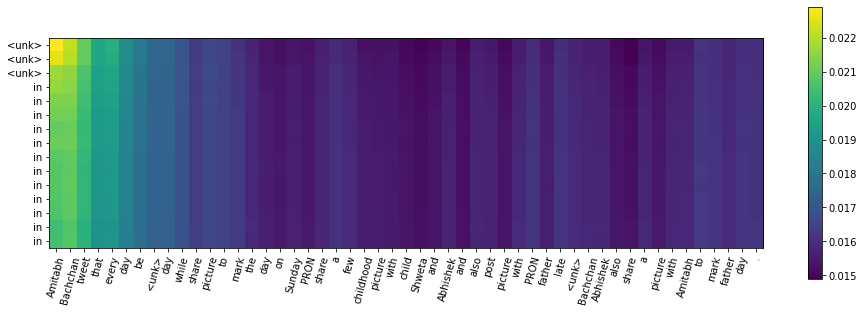

tensor([[0.0229, 0.0222, 0.0210, 0.0197, 0.0199, 0.0189, 0.0181, 0.0176, 0.0175,
         0.0170, 0.0163, 0.0166, 0.0165, 0.0161, 0.0157, 0.0153, 0.0152, 0.0154,
         0.0153, 0.0156, 0.0159, 0.0156, 0.0153, 0.0153, 0.0153, 0.0151, 0.0150,
         0.0151, 0.0153, 0.0151, 0.0155, 0.0154, 0.0151, 0.0155, 0.0159, 0.0154,
         0.0160, 0.0157, 0.0156, 0.0155, 0.0151, 0.0149, 0.0154, 0.0152, 0.0155,
         0.0155, 0.0161, 0.0160, 0.0157, 0.0160, 0.0160, 0.0160, 0.0159, 0.0157,
         0.0151, 0.0160, 0.0167, 0.0161, 0.0172, 0.0183, 0.0203],
        [0.0226, 0.0220, 0.0210, 0.0197, 0.0199, 0.0189, 0.0181, 0.0176, 0.0175,
         0.0170, 0.0163, 0.0166, 0.0165, 0.0161, 0.0157, 0.0153, 0.0152, 0.0154,
         0.0153, 0.0156, 0.0159, 0.0157, 0.0153, 0.0153, 0.0153, 0.0151, 0.0150,
         0.0152, 0.0154, 0.0151, 0.0156, 0.0155, 0.0151, 0.0155, 0.0159, 0.0155,
         0.0160, 0.0157, 0.0156, 0.0155, 0.0151, 0.0149, 0.0154, 0.0152, 0.0155,
         0.0155, 0.0161, 0.0160, 0.0157, 0.

Original : <sos> model actor Milind Soman take to Instagram to share an old picture of   PRON   with actress Aishwarya Rai Milind can be see wear a black shirt in the photograph caption Throwback Thursday # <unk> <unk> caption reveal that the photograph be take in the year 1993 <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 
['--------------------------------------------------------------------------------']
Target : <sos> Milind Soman share old picture with Aishwarya Rai <eos> 
['--------------------------------------------------------------------------------']
Summary : <sos> to  to  to  to  to  to  to  to  to  to  to  to  to  to  <eos>
['================================================================================']
ROUGE-1 [precision] : 0.0| [recall] : {np.round(value["r"] * 100, 2)}| [f-score] : {np.round(value["f"] * 100, 2)}
ROUGE-2 [precision] : 0.0| [recall] : {np.round(value["r"] * 100, 2)}| [f-score] : {np.round(value["f"] * 100, 2)}
ROUGE-L [precision] : 0.0| [recall] :

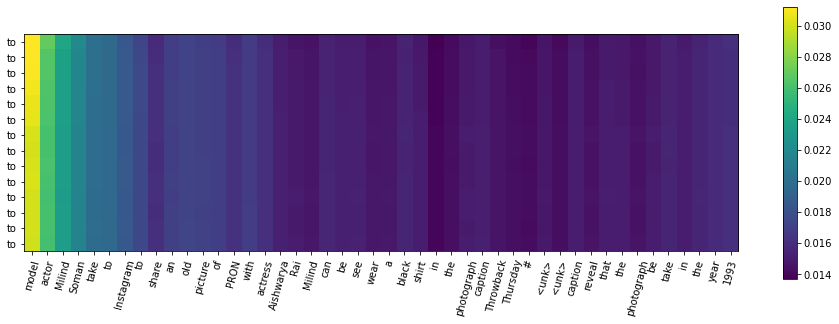

tensor([[0.0312, 0.0270, 0.0241, 0.0219, 0.0201, 0.0198, 0.0185, 0.0174, 0.0159,
         0.0169, 0.0172, 0.0170, 0.0168, 0.0160, 0.0168, 0.0160, 0.0151, 0.0147,
         0.0146, 0.0154, 0.0151, 0.0151, 0.0145, 0.0146, 0.0154, 0.0149, 0.0137,
         0.0142, 0.0149, 0.0151, 0.0145, 0.0142, 0.0140, 0.0147, 0.0142, 0.0150,
         0.0144, 0.0150, 0.0149, 0.0145, 0.0149, 0.0154, 0.0150, 0.0154, 0.0158,
         0.0161, 0.0159, 0.0163, 0.0162, 0.0167, 0.0157, 0.0174, 0.0185, 0.0197,
         0.0201, 0.0215, 0.0204, 0.0213, 0.0227],
        [0.0312, 0.0265, 0.0237, 0.0217, 0.0202, 0.0197, 0.0186, 0.0175, 0.0160,
         0.0170, 0.0172, 0.0170, 0.0169, 0.0162, 0.0168, 0.0161, 0.0152, 0.0149,
         0.0147, 0.0154, 0.0152, 0.0152, 0.0147, 0.0148, 0.0153, 0.0149, 0.0139,
         0.0143, 0.0149, 0.0151, 0.0146, 0.0143, 0.0142, 0.0148, 0.0143, 0.0150,
         0.0145, 0.0150, 0.0149, 0.0145, 0.0149, 0.0154, 0.0151, 0.0155, 0.0158,
         0.0160, 0.0158, 0.0163, 0.0161, 0.0165, 0.0157, 0.

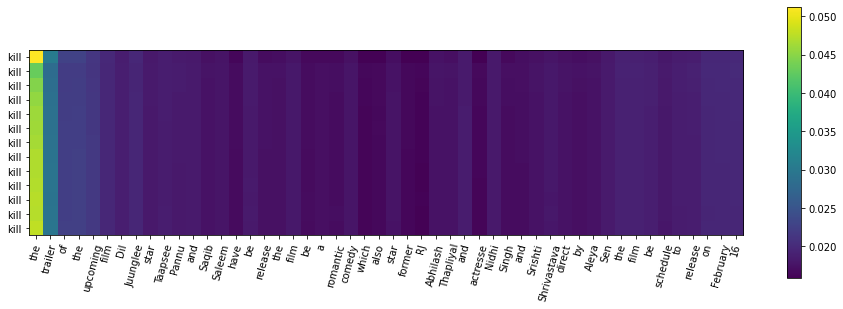

tensor([[0.0513, 0.0306, 0.0228, 0.0228, 0.0215, 0.0199, 0.0186, 0.0197, 0.0183,
         0.0186, 0.0183, 0.0183, 0.0174, 0.0177, 0.0165, 0.0182, 0.0170, 0.0172,
         0.0178, 0.0167, 0.0167, 0.0168, 0.0175, 0.0161, 0.0161, 0.0171, 0.0159,
         0.0158, 0.0176, 0.0173, 0.0184, 0.0160, 0.0182, 0.0167, 0.0171, 0.0174,
         0.0179, 0.0174, 0.0171, 0.0174, 0.0182, 0.0191, 0.0189, 0.0189, 0.0182,
         0.0186, 0.0187, 0.0198, 0.0198, 0.0198, 0.0230, 0.0274],
        [0.0430, 0.0283, 0.0221, 0.0222, 0.0213, 0.0198, 0.0188, 0.0195, 0.0184,
         0.0187, 0.0186, 0.0184, 0.0177, 0.0179, 0.0170, 0.0184, 0.0176, 0.0175,
         0.0181, 0.0171, 0.0172, 0.0171, 0.0178, 0.0166, 0.0167, 0.0176, 0.0166,
         0.0164, 0.0178, 0.0177, 0.0184, 0.0167, 0.0183, 0.0173, 0.0173, 0.0177,
         0.0182, 0.0178, 0.0175, 0.0177, 0.0185, 0.0192, 0.0192, 0.0190, 0.0185,
         0.0188, 0.0191, 0.0199, 0.0200, 0.0200, 0.0227, 0.0264],
        [0.0447, 0.0287, 0.0222, 0.0223, 0.0214, 0.0198, 0

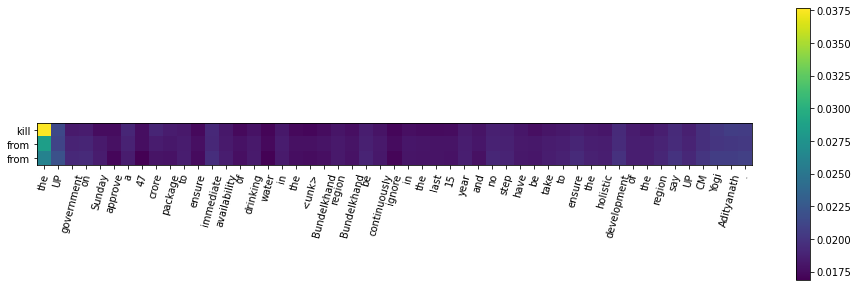

tensor([[0.0377, 0.0214, 0.0184, 0.0185, 0.0176, 0.0175, 0.0191, 0.0177, 0.0190,
         0.0184, 0.0183, 0.0174, 0.0193, 0.0182, 0.0174, 0.0179, 0.0172, 0.0182,
         0.0174, 0.0172, 0.0175, 0.0181, 0.0177, 0.0185, 0.0180, 0.0173, 0.0177,
         0.0176, 0.0175, 0.0176, 0.0184, 0.0180, 0.0187, 0.0186, 0.0181, 0.0177,
         0.0180, 0.0182, 0.0186, 0.0183, 0.0181, 0.0193, 0.0185, 0.0181, 0.0186,
         0.0193, 0.0187, 0.0197, 0.0202, 0.0206, 0.0206, 0.0216, 0.0229],
        [0.0285, 0.0211, 0.0189, 0.0190, 0.0183, 0.0178, 0.0188, 0.0176, 0.0184,
         0.0182, 0.0185, 0.0178, 0.0192, 0.0184, 0.0179, 0.0183, 0.0174, 0.0184,
         0.0178, 0.0178, 0.0179, 0.0183, 0.0180, 0.0187, 0.0183, 0.0176, 0.0181,
         0.0181, 0.0180, 0.0180, 0.0185, 0.0181, 0.0189, 0.0188, 0.0183, 0.0182,
         0.0185, 0.0186, 0.0190, 0.0187, 0.0185, 0.0194, 0.0186, 0.0186, 0.0189,
         0.0195, 0.0189, 0.0197, 0.0201, 0.0202, 0.0203, 0.0212, 0.0213],
        [0.0261, 0.0220, 0.0192, 0.0194, 0

KeyboardInterrupt: 

In [151]:
best_val_loss = None
for e in notebook.tqdm(range(1, epochs+1)):
    train(e, seq2seq, optimizer, scheduler, train_iter, text_size, grad_clip, TEXT)
    val_loss = evaluate(seq2seq, val_iter, text_size, TEXT)
    print(f'[Epoch: {e}] val_loss: {val_loss} | val_pp: {math.exp(val_loss)}')

    # Save the model if the validation loss is the best we've seen so far.
    if not best_val_loss or val_loss < best_val_loss:
        print("[!] saving model...")
        if not os.path.isdir(".save"):
            os.makedirs(".save")
        torch.save(seq2seq.state_dict(), './.save/seq2seq_%d.pt' % (e))
        best_val_loss = val_loss
test_loss = evaluate(seq2seq, test_iter, text_size, TEXT)
print(f'[TEST] loss: {test_loss}')